In [1]:
%pylab inline
import os

import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
from scipy.stats import ortho_group
import matplotlib.pyplot as plt
import torch
import sklearn
from sklearn import datasets

from irim.core.invertible_layers import Housholder1x1, RevNetLayer
from irim.core.invert_to_learn import InvertibleModule

Populating the interactive namespace from numpy and matplotlib


## Visualisation of the data generating process

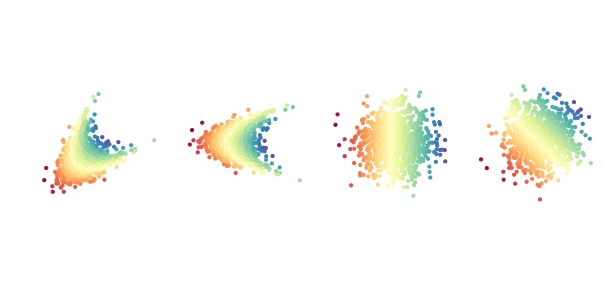

In [2]:
numpy.random.seed(seed=10)
    
figure(figsize=(10,5), frameon=False)
mean = [0, 0]
cov = [[1, 0], [0, 1]]
ortho_mat = np.array([[cos(0.25*pi),-sin(0.25*pi)],[sin(0.25*pi), cos(0.25*pi)]])


x, y = multivariate_normal(mean, cov, 1000).T
color = x
x = x + 0.5*y**2
out = np.dot(np.concatenate((x[:,None],y[:,None]),1),ortho_mat.T)
data = out.copy()
x, y = out[:,0], out[:,1]

subplot(1,4,1)
scatter(x, y, c=color, cmap=plt.cm.Spectral,s=10)
axes = plt.gca()
axis('equal')
axis('off')

out = np.dot(np.concatenate((x[:,None],y[:,None]),1),ortho_mat)
x, y = out[:,0], out[:,1]
subplot(1,4,2)
scatter(x, y, c=color, cmap=plt.cm.Spectral,s=10)
axis('equal')
axis('off')

y = y
x = x - 0.5*y**2
subplot(1,4,3)
scatter(x, y, c=color, cmap=plt.cm.Spectral,s=10)
axes = plt.gca()
axis('equal')
axis('off')


out = np.dot(np.concatenate((x[:,None],y[:,None]),1),ortho_mat.T)
x, y = out[:,0], out[:,1]
subplot(1,4,4)
scatter(x, y, c=color, cmap=plt.cm.Spectral,s=10)
axes = plt.gca()
axis('equal')
axis('off')
savefig('flow.pdf', dpi=300, bbox_inches='tight', pad_inches=0)

In [3]:
class layer(InvertibleModule):
    def __init__(self):
        super(layer, self).__init__()
        self.rev_block = RevNetLayer(2, 4, dilation=1, conv_nd=1)
        self.householder = Housholder1x1(2,conv_nd=1)
        
    def forward(self,x):
        x = self.householder.forward(x)
        x = self.rev_block.forward(x)
        x = self.householder.reverse(x)
        return x
    
    def reverse(self,x):
        x = self.householder.forward(x)
        x = self.rev_block.reverse(x)
        x = self.householder.reverse(x)
        return x

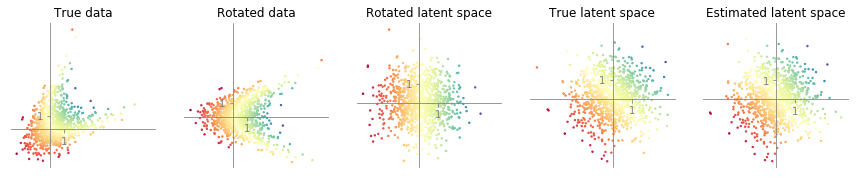

In [4]:
numpy.random.seed(seed=1)
torch.manual_seed(1)

figure(figsize=(15,8), frameon=False)
mean = [0, 0]
cov = [[1, 0], [0, 1]]
ortho_mat = np.array([[cos(0.25*pi),-sin(0.25*pi)],[sin(0.25*pi), cos(0.25*pi)]])

x, y = multivariate_normal(mean, cov, 1000).T
color = x
x = x + 0.5*y**2
out = np.dot(np.concatenate((x[:,None],y[:,None]),1),ortho_mat.T)
data = out.copy()
x, y = out[:,0], out[:,1]

subplot(1,5,1)
scatter(x, y, c=color, cmap=plt.cm.Spectral,s=2)
axes = plt.gca()
ax = gca()
ax.spines['left'].set_color('grey')
ax.spines['bottom'].set_color('grey')
ax.spines['left'].set_position('zero')
ax.spines['bottom'].set_position('zero')

# Eliminate upper and right axes
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')

# # Show ticks in the left and lower axes only
ax.set_xticks([1.])
ax.set_yticks([1.])
ax.tick_params(axis='x', colors='grey')
ax.tick_params(axis='y', colors='grey')
axis('square')
title('True data')


out = np.dot(np.concatenate((x[:,None],y[:,None]),1),ortho_mat)
x, y = out[:,0], out[:,1]
subplot(1,5,2)
scatter(x, y, c=color, cmap=plt.cm.Spectral,s=2)
ax = gca()
ax.spines['left'].set_color('grey')
ax.spines['bottom'].set_color('grey')
ax.spines['left'].set_position('zero')
ax.spines['bottom'].set_position('zero')

# Eliminate upper and right axes
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')

# # Show ticks in the left and lower axes only
ax.set_xticks([1.])
ax.set_yticks([1.])
ax.tick_params(axis='x', colors='grey')
ax.tick_params(axis='y', colors='grey')
axis('square')
title('Rotated data')


y = y
x = x - 0.5*y**2
subplot(1,5,3)
scatter(x, y, c=color, cmap=plt.cm.Spectral,s=2)
axes = plt.gca()
ax = gca()
ax.spines['left'].set_color('grey')
ax.spines['bottom'].set_color('grey')
ax.spines['left'].set_position('zero')
ax.spines['bottom'].set_position('zero')

# Eliminate upper and right axes
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')

# # Show ticks in the left and lower axes only
ax.set_xticks([1.])
ax.set_yticks([1.])
ax.tick_params(axis='x', colors='grey')
ax.tick_params(axis='y', colors='grey')
axis('square')
title('Rotated latent space')


out = np.dot(np.concatenate((x[:,None],y[:,None]),1),ortho_mat.T)
x, y = out[:,0], out[:,1]
subplot(1,5,4)
scatter(x, y, c=color, cmap=plt.cm.Spectral,s=2)
ax = gca()
ax.spines['left'].set_color('grey')
ax.spines['bottom'].set_color('grey')
ax.spines['left'].set_position('zero')
ax.spines['bottom'].set_position('zero')

# Eliminate upper and right axes
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')

# # Show ticks in the left and lower axes only
ax.set_xticks([1.])
ax.set_yticks([1.])
ax.tick_params(axis='x', colors='grey')
ax.tick_params(axis='y', colors='grey')
axis('square')
title('True latent space')

train_data = torch.Tensor(data).reshape(-1,2,1)
model = layer()
optimizer = torch.optim.Adam(model.parameters(), 1e-3)

for i in range(1000):
    optimizer.zero_grad()
    z = model.forward(train_data)
    loss = torch.mean(z**2)
    loss.backward()
    optimizer.step()

subplot(1,5,5)
scatter(z.squeeze(2).detach().numpy()[:,0], z.squeeze(2).detach().numpy()[:,1], c=color, cmap=plt.cm.Spectral,s=2)
ax = gca()
ax.spines['left'].set_color('grey')
ax.spines['bottom'].set_color('grey')
ax.spines['left'].set_position('zero')
ax.spines['bottom'].set_position('zero')

# Eliminate upper and right axes
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')

# # Show ticks in the left and lower axes only
ax.set_xticks([1.])
ax.set_yticks([1.])
ax.tick_params(axis='x', colors='grey')
ax.tick_params(axis='y', colors='grey')
axis('square')
title('Estimated latent space')

savefig('flow.pdf', dpi=300, bbox_inches='tight', pad_inches=0)

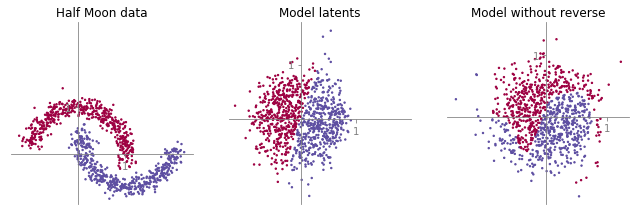

In [5]:
N_ITER = 3000
N_LAYERS = 10
N_HIDDEN = 4

numpy.random.seed(seed=10)

class layer(torch.nn.Module):
    def __init__(self):
        super(layer, self).__init__()
        self.rev_block = RevNetLayer(2, N_HIDDEN, dilation=1, conv_nd=1)
        self.householder = Housholder1x1(2,conv_nd=1)
        
    def forward(self,x):
        x = self.householder.forward(x)
        x = self.rev_block.forward(x)
        x = self.householder.reverse(x)
        return x
    
class layer_no_reverse(layer):
    def forward(self,x):
        x = self.householder.forward(x)
        x = self.rev_block.forward(x)
        return x
    
data, color = sklearn.datasets.make_moons(n_samples=1000, shuffle=True, noise=.1, random_state=1)
ortho_mat = np.array([[cos(0.06*pi),-sin(0.06*pi)],[sin(0.06*pi), cos(0.06*pi)]])
data = np.dot(data,ortho_mat)
x, y = data[:,0], data[:,1]
# color = x

figure(figsize=(15,8))
subplot(1,4,1)
scatter(x, y, c=color, cmap=plt.cm.Spectral,s=2)
ax = gca()
ax.spines['left'].set_color('grey')
ax.spines['bottom'].set_color('grey')
ax.spines['left'].set_position('zero')
ax.spines['bottom'].set_position('zero')

# Eliminate upper and right axes
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')

# # Show ticks in the left and lower axes only
ax.set_xticks([1.])
ax.set_yticks([1.])
ax.tick_params(axis='x', colors='grey')
ax.tick_params(axis='y', colors='grey')
axis('square')
title('Half Moon data')

model = torch.nn.Sequential(*[layer() for i in range(N_LAYERS)])
optimizer = torch.optim.Adam(model.parameters(), 1e-3)
train_data = torch.Tensor(data).reshape(-1,2,1)
for i in range(N_ITER):
    optimizer.zero_grad()
    z = model.forward(train_data)
    loss = torch.mean(z**2)
    loss.backward()
    optimizer.step()

subplot(1,4,2)
scatter(z.squeeze(2).detach().numpy()[:,0], z.squeeze(2).detach().numpy()[:,1], c=color, cmap=plt.cm.Spectral,s=2)
title(loss.item())
ax = gca()
ax.spines['left'].set_color('grey')
ax.spines['bottom'].set_color('grey')
ax.spines['left'].set_position('zero')
ax.spines['bottom'].set_position('zero')

# Eliminate upper and right axes
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')

# # Show ticks in the left and lower axes only
ax.set_xticks([1.])
ax.set_yticks([1.])
ax.tick_params(axis='x', colors='grey')
ax.tick_params(axis='y', colors='grey')
axis('square')
title('Model latents')

model = torch.nn.Sequential(*[layer_no_reverse() for i in range(N_LAYERS)])
optimizer = torch.optim.Adam(model.parameters(), 1e-3)
train_data = torch.Tensor(data).reshape(-1,2,1)
for i in range(N_ITER):
    optimizer.zero_grad()
    z = model.forward(train_data)
    loss = torch.mean(z**2)
    loss.backward()
    optimizer.step()

subplot(1,4,3)
scatter(z.squeeze(2).detach().numpy()[:,0], z.squeeze(2).detach().numpy()[:,1], c=color, cmap=plt.cm.Spectral,s=2)
title(loss.item())
ax = gca()
ax.spines['left'].set_color('grey')
ax.spines['bottom'].set_color('grey')
ax.spines['left'].set_position('zero')
ax.spines['bottom'].set_position('zero')

# Eliminate upper and right axes
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')

# # Show ticks in the left and lower axes only
ax.set_xticks([1.])
ax.set_yticks([1.])
ax.tick_params(axis='x', colors='grey')
ax.tick_params(axis='y', colors='grey')
axis('square')
title('Model without reverse')
savefig('two_moons_flow_comparison.pdf', dpi=300, bbox_inches='tight', pad_inches=0)